In [182]:
import torch
from menuinst.utils import data_path
from numpy.ma.extras import average
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import warnings

from typing_extensions import dataclass_transform
from xgboost import train
from tqdm import tqdm
warnings.filterwarnings('ignore')
import requests
import zipfile
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool
from torchvision import datasets
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split # Importing train_test_split

import shap
shap.initjs()
torch.__version__

'2.4.1'

In [183]:
# Define paths
base_path = "/Users/ziaulhoque/Desktop/pytorchPractise/data/CVD_IMAGE/Image"
yes_path = os.path.join(base_path, 'YES')
no_path = os.path.join(base_path, 'NO')

# Collect image paths and labels
data = []

# Read 'YES' folder
for filename in os.listdir(yes_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.abspath(os.path.join(yes_path, filename))
        data.append([file_path, 'YES'])  # '1' for positive disease

# Read 'NO' folder
for filename in os.listdir(no_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.abspath(os.path.join(no_path, filename))
        data.append([file_path, 'NO'])  # '0' for no disease

# Create a DataFrame
df = pd.DataFrame(data, columns=['file_path', 'label'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# Save the complete CSV
csv_path = os.path.join(base_path, "ecg_dataset.csv")
df.to_csv(csv_path, index=False)
print(f"CSV file saved at: {csv_path}")

# Load the CSV
df = pd.read_csv(csv_path)

# Split into features (X) and labels (y)
X = df['file_path']
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the sizes
print("Training data size:", len(X_train))
print("Testing data size:", len(X_test))

CSV file saved at: /Users/ziaulhoque/Desktop/pytorchPractise/data/CVD_IMAGE/Image/ecg_dataset.csv
Training data size: 742
Testing data size: 186


In [184]:
y

0       NO
1       NO
2      YES
3      YES
4      YES
      ... 
923    YES
924    YES
925     NO
926    YES
927    YES
Name: label, Length: 928, dtype: object

In [185]:
# Check class distribution
print("Class distribution in the dataset:")
class_counts = y.value_counts()
print(class_counts)

# Percentage of each class
print("Class distribution percentage:")
print(class_counts / len(y) * 100)

Class distribution in the dataset:
label
YES    644
NO     284
Name: count, dtype: int64
Class distribution percentage:
label
YES    69.396552
NO     30.603448
Name: count, dtype: float64


In [186]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the sizes
print("Training data size:", len(X_train))
print("Testing data size:", len(X_test))

Training data size: 742
Testing data size: 186


In [187]:
y_train

772    YES
193    YES
344    YES
776    YES
838    YES
      ... 
411    YES
156     NO
307    YES
568     NO
636    YES
Name: label, Length: 742, dtype: object

In [188]:
YES = X_train[y_train == "YES"]
NO = X_train[y_train == "NO"]

In [189]:
len(YES),len(NO)

(515, 227)

In [190]:
labels = ['YES', 'NO']

# Create the base directory 'Data' and subdirectories
base_dir = 'CVD_IMAGE'
image_dir = os.path.join(base_dir, 'Image')
train_dir = os.path.join(image_dir, 'Train')
test_dir = os.path.join(image_dir, 'Test')

In [191]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subfolders for each label inside 'train' and 'test'
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

In [192]:
# Function to copy images to the appropriate folders based on the labels
def copy_images_to_folders(X, y, folder_path):
    for label in labels:
        # Get the image file paths corresponding to the label
        image_paths = X[y == label].values

        # Create the label folder path
        label_folder = os.path.join(folder_path, label)

        for img_path in image_paths:
            # Construct the full image source and destination paths
            src = os.path.join(img_path)  # Update to your images folder path
            image_name = img_path.split('/')[-1]

            dest = os.path.join(label_folder, image_name)

            # Copy the image to the destination folder
            if(os.path.exists(dest)): break
            shutil.copy(src, dest)

# Copy images for training set
copy_images_to_folders(X_train, y_train, train_dir)

# Copy images for testing set
copy_images_to_folders(X_test, y_test, test_dir)

print("Images successfully copied to train and test directories.")

Images successfully copied to train and test directories.


In [193]:
data_path = Path("/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE")

image_path = data_path / "Image"

In [194]:
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"{image_path} directory does not exist.")

/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image directory exists.


In [195]:
def walk_trough_dir(dir_path):
    """Walks through a directory and returns all images in that directory."""
    for dir_path,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and  {len(filenames)} images in '{dir_path}'.")


In [196]:
walk_trough_dir(image_path)

There are 2 directories and  0 images in '/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image'.
There are 2 directories and  0 images in '/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Test'.
There are 0 directories and  58 images in '/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Test/NO'.
There are 0 directories and  131 images in '/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Test/YES'.
There are 2 directories and  0 images in '/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Train'.
There are 0 directories and  227 images in '/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Train/NO'.
There are 0 directories and  516 images in '/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Train/YES'.


In [197]:
# Setup train and testing paths
train_dir = image_path / "Train"
test_dir = image_path / "Test"

train_dir, test_dir

(PosixPath('/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Train'),
 PosixPath('/Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Test'))

Random image path: /Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Train/YES/PMI(122).jpg
Image class: YES
Image height: 1572
Image width: 2213


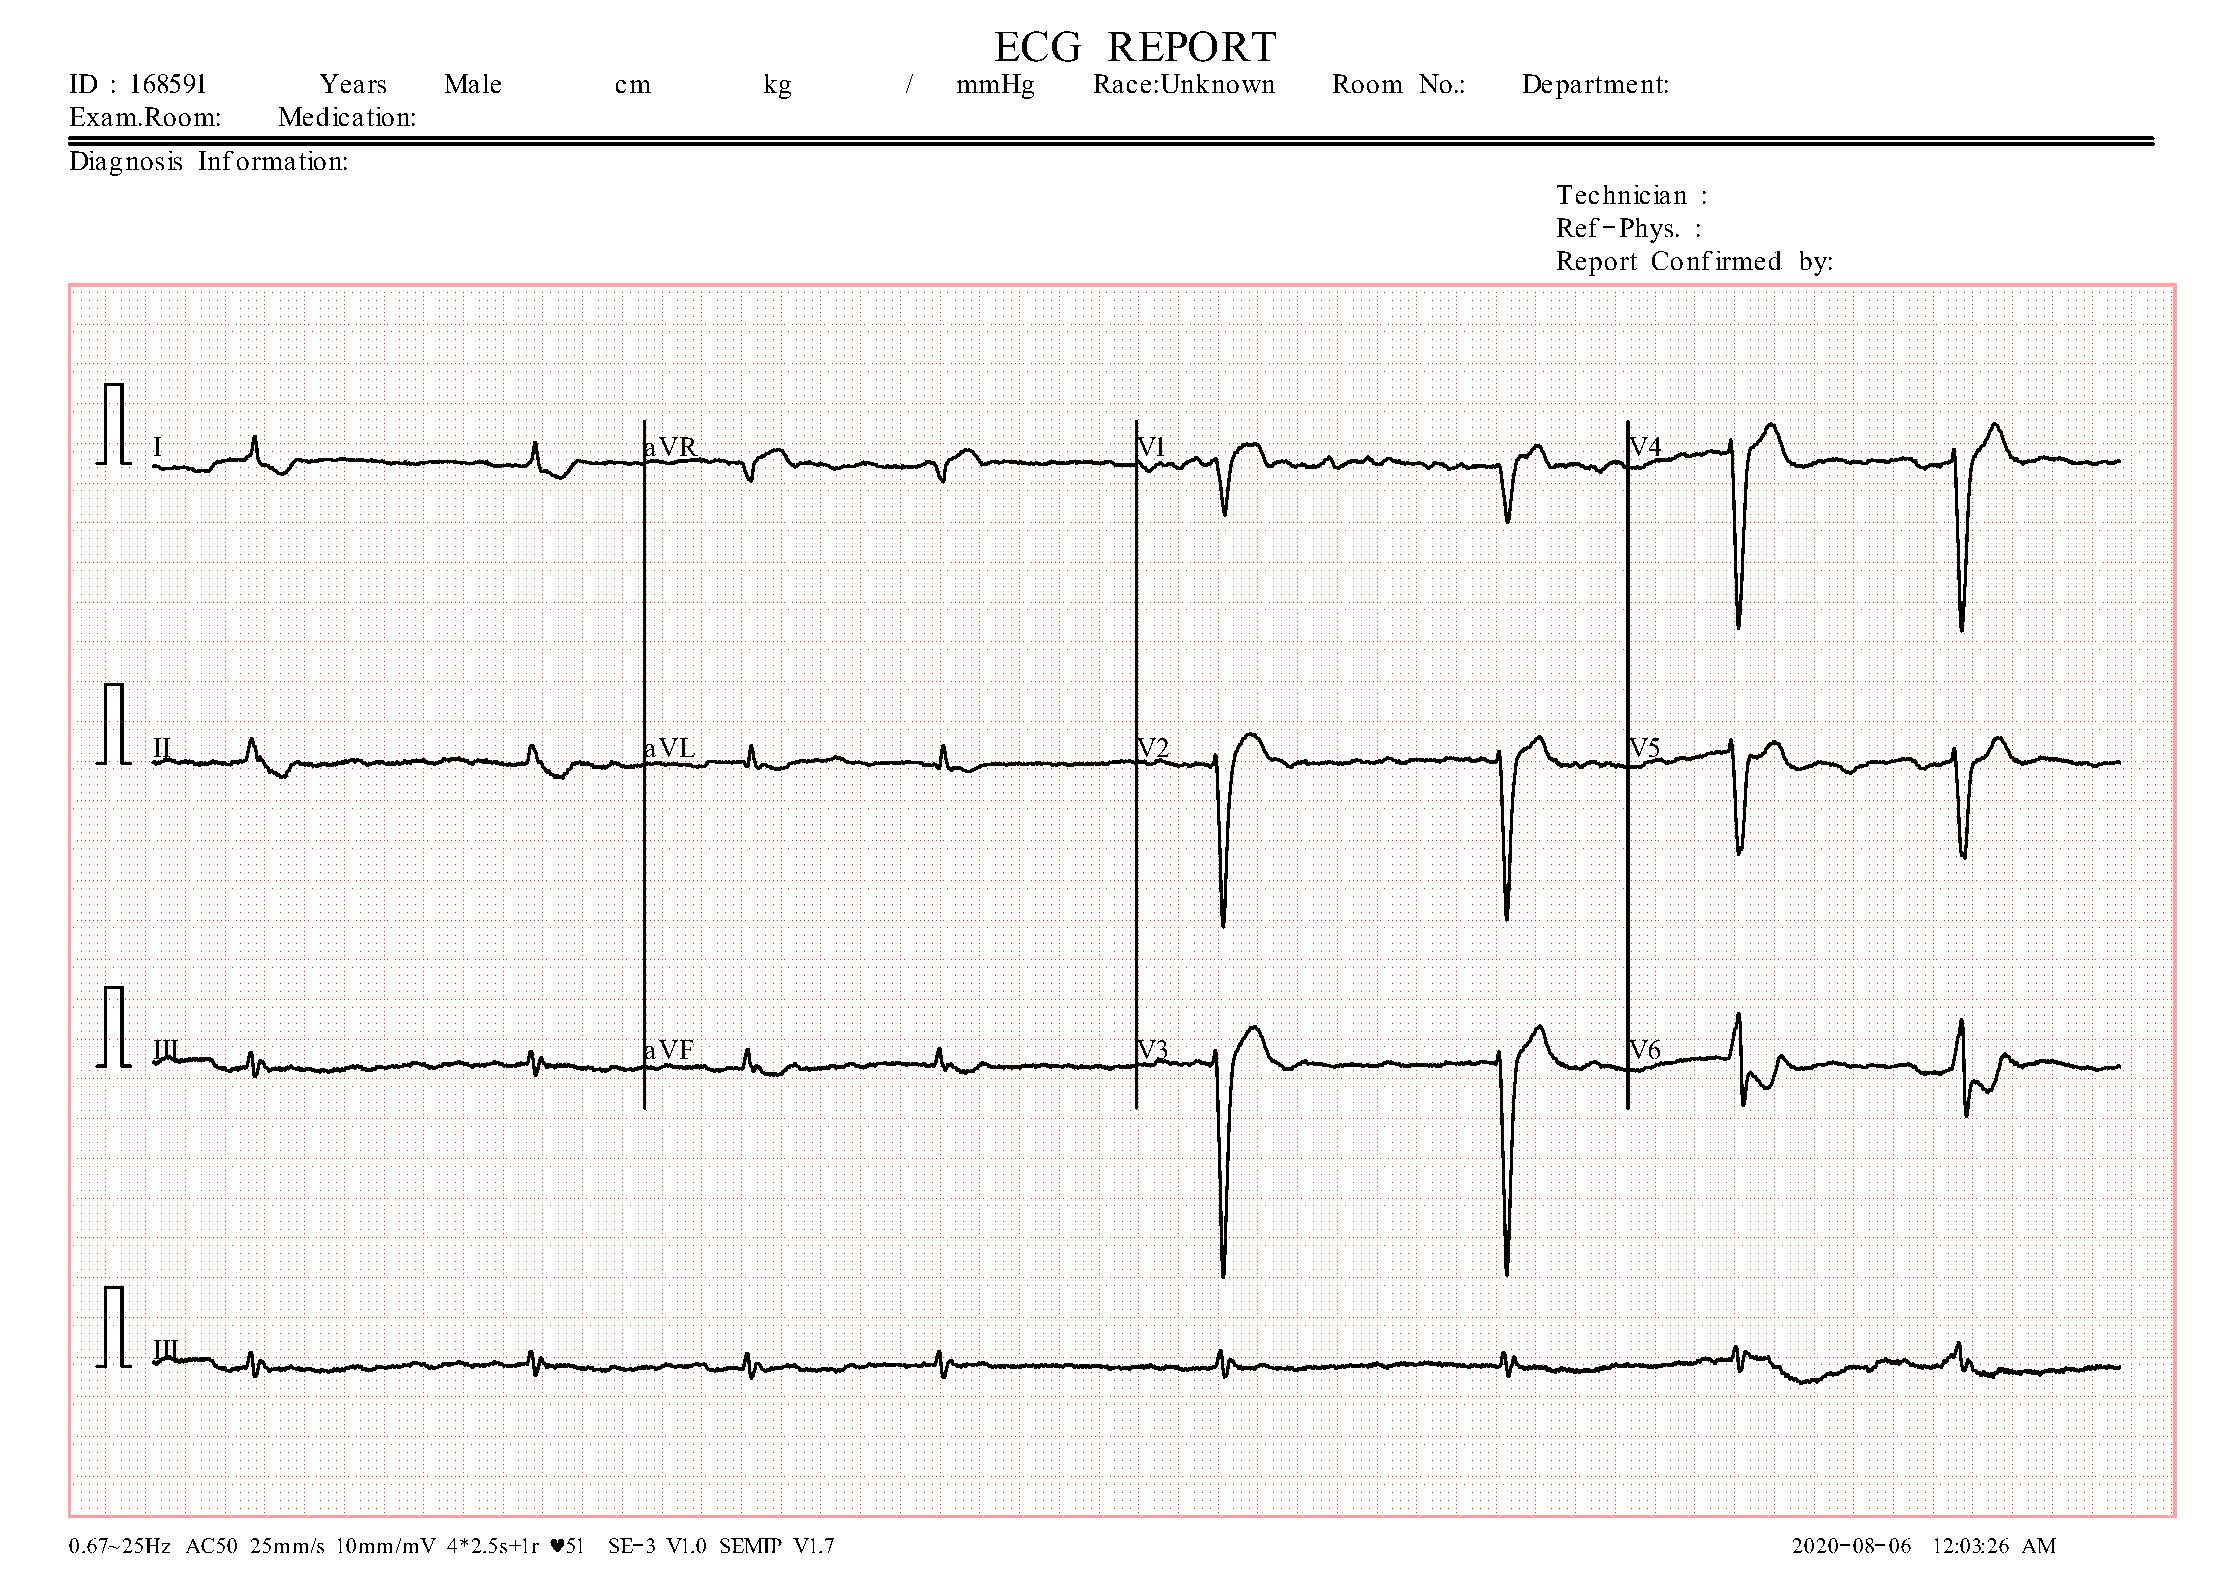

In [198]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

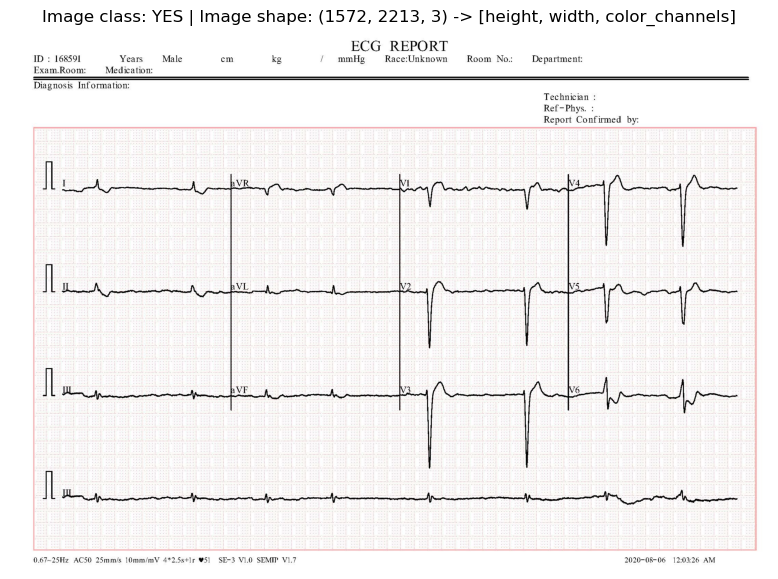

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# Data Into Pytorch


In [200]:
dataclass_transform = transforms.Compose([
    #resize the image
    transforms.Resize(size=(212,212)),
    #flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),#p = probability of flip, 0.5=50%
    #turn the image into a torch.tensor
    transforms.ToTensor()##this also converts all pixxel values from 0 to 255 to be between 0.0 to 1.0


])

In [201]:
img.size

(2213, 1572)

In [202]:
dataclass_transform(img)


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [203]:
def plot_transformed_images(image_paths,transform,n=None):
    random.seed(18122005)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Orginal image\n{f.size}")
            ax[0].axis('off')
            #transfoming image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed image\n{transformed_image.shape}")
            ax[1].axis('off')
            fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

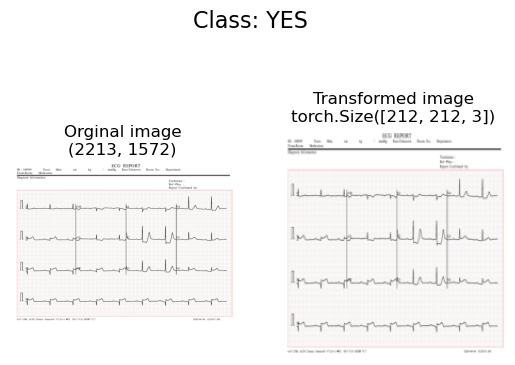

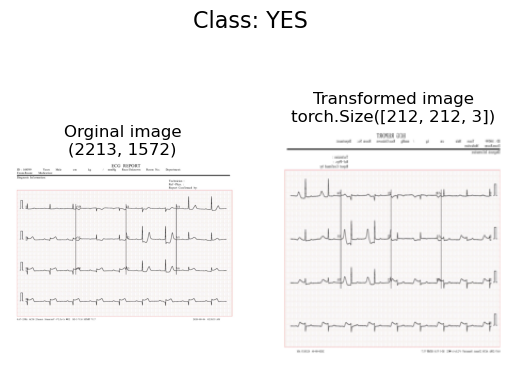

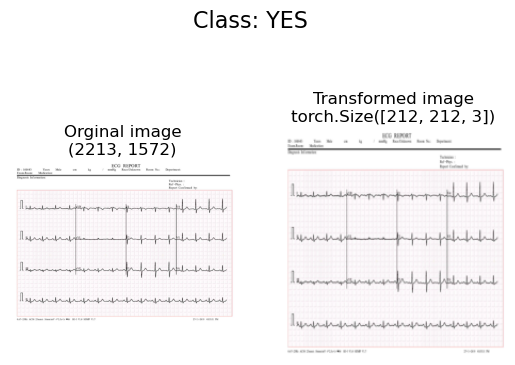

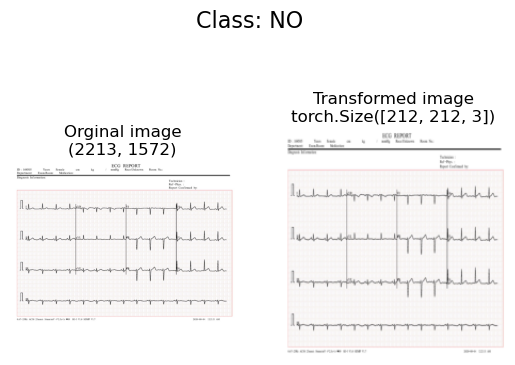

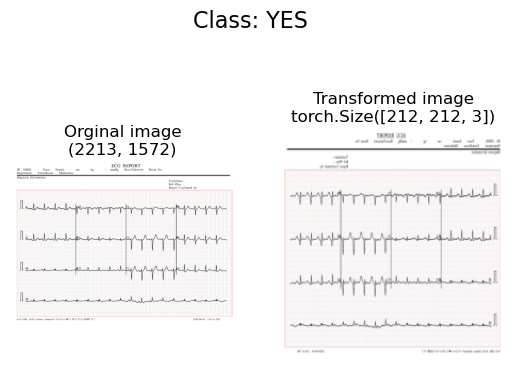

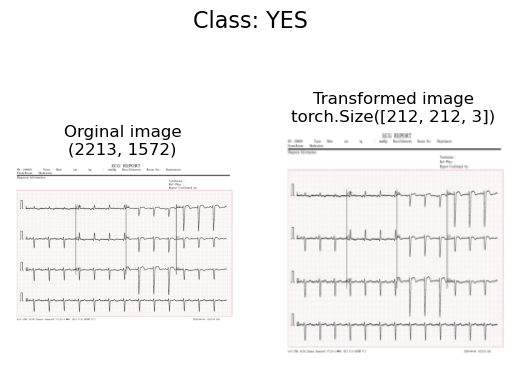

In [204]:
plot_transformed_images(image_paths=image_path_list,transform=dataclass_transform,n=6)

# Loading Image data using ImageFolder

In [205]:
train_data = datasets.ImageFolder(train_dir, transform=dataclass_transform,target_transform=None)
test_data = datasets.ImageFolder(test_dir, transform=dataclass_transform)
print(f"Train data : \n{train_data}\nTest data : \n{test_data}")

Train data : 
Dataset ImageFolder
    Number of datapoints: 743
    Root location: /Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Train
    StandardTransform
Transform: Compose(
               Resize(size=(212, 212), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data : 
Dataset ImageFolder
    Number of datapoints: 189
    Root location: /Users/ziaulhoque/Desktop/pytorchPractise/CVD_IMAGE/Image/Test
    StandardTransform
Transform: Compose(
               Resize(size=(212, 212), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [206]:
class_names = train_data.classes
class_names

['NO', 'YES']

In [207]:
class_dict = dict(zip(class_names, range(len(class_names))))
class_dict

{'NO': 0, 'YES': 1}

In [208]:
class_dict = train_data.class_to_idx
class_dict

{'NO': 0, 'YES': 1}

In [209]:
len(train_data),len(test_data)

(743, 189)

In [210]:
img,label = train_data[0][0],train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape:\n{img.shape}")
print(f"Image datatype:\n{img.dtype}")
print(f"Image label:{label}")
print(f"Label datatype:{type(label)}")


Image tensor:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Image shape:
torch.Size([3, 212, 212])
Image datatype:
torch.float32
Image label:0
Label datatype:<class 'int'>


In [211]:
for batch in train_data:
    img, label = batch
    print(f"Image tensor:\n{img}")
    print(f"Image shape:\n{img.shape}")
    print(f"Image datatype:\n{img.dtype}")
    print(f"Image label:{label}")
    print(f"Label datatype:{type(label)}")
    break  # Only print the first batch to avoid looping over everything


Image tensor:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Image shape:
torch.Size([3, 212, 212])
Image datatype:
torch.float32
Image label:0
Label datatype:<class 'int'>


Original shape: torch.Size([3, 212, 212]) -> [color_channels, height, width]
Image permute shape: torch.Size([212, 212, 3]) -> [height, width, color_channels]


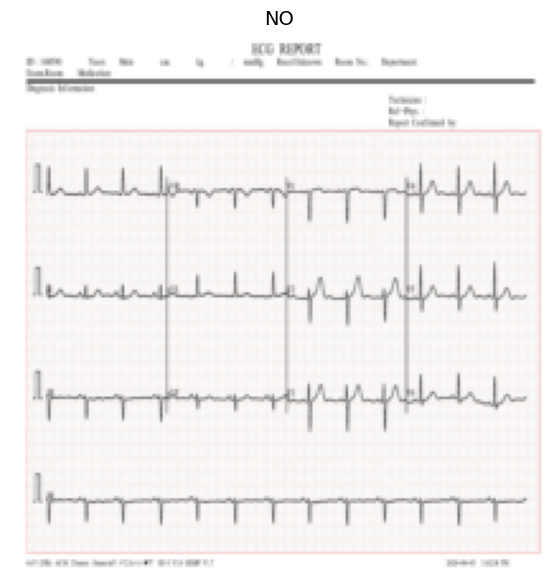

In [212]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [213]:
os.cpu_count()

8

In [214]:
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

print(f"Training DataLoader has {len(train_dataloader)} batches.")
print(f"Testing DataLoader has {len(test_dataloader)} batches.")


Training DataLoader has 743 batches.
Testing DataLoader has 189 batches.


In [215]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([1, 3, 212, 212]), torch.Size([1]))

In [216]:
img.unsqueeze(dim=0).shape

torch.Size([1, 3, 212, 212])

Image size: torch.Size([3, 212, 212])
Label: 1, label size: torch.Size([])


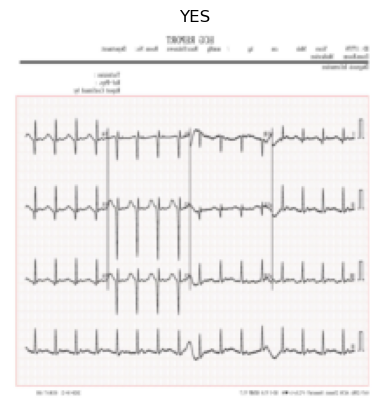

In [217]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.permute(1,2,0), cmap=plt.cm.RdYlBu)
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [218]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([3, 212, 212]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 44944]) -> [color_channels, height*width]


In [219]:
from torch import nn
class CVD(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [220]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = CVD(input_shape=134832, # one for every pixel (28x28)
                              hidden_units=10, # how many units in the hidden layer
                              output_shape=len(class_names) # one for every class
                              )
model_0.to("cpu") # keep model on CPU to begin with

CVD(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=134832, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [221]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    # Note: you need the "raw" GitHub URL for this to work
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [222]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [223]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Device Agnostic Code

In [224]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"using device: {device}")

using device: mps


In [225]:
# Create a model with non-linear and linear layers
class CVD1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [226]:
torch.manual_seed(42)
model_1 = CVD1(input_shape=134832, # number of input features
                              hidden_units=10,
                              output_shape=len(class_names) # number of output classes desired
                              ).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='mps', index=0)

In [227]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [228]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
                                    )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [229]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 1
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
               model=model_1,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn
               )
    test_step(data_loader=test_dataloader,
              model=model_1,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn
              )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.86423 | Train accuracy: 30.42%


100%|█████████████████████████████████████████████| 1/1 [00:50<00:00, 50.52s/it]

Test loss: 0.69315 | Test accuracy: 30.69%

Train time on mps: 50.557 seconds


In [230]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
                             loss_fn=loss_fn, accuracy_fn=accuracy_fn,
                             device=device
                             )
model_1_results

{'model_name': 'CVD1',
 'model_loss': 0.6931462287902832,
 'model_acc': 30.687830687830687}

# Beuilding CNN

In [231]:
import torch
from torch import nn

class CVD2(nn.Module):
    """
    Model architecture for skin disease classification.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),  # Keep spatial dimensions unchanged
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Halve the spatial dimensions
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Halve the spatial dimensions again
        )

        # Calculate the flattened size dynamically
        with torch.no_grad():
            sample_input = torch.randn(1, input_shape, 212, 212)  # Use the specified input size
            x = self.block_1(sample_input)
            x = self.block_2(x)
            flattened_size = x.numel() // x.size(0)  # Calculate features per sample

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_size, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


# Instantiate the model
torch.manual_seed(42)
model_2 = CVD2(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_2


CVD2(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=28090, out_features=2, bias=True)
  )
)

In [232]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 1
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
               model=model_2,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
               )
    test_step(data_loader=test_dataloader,
              model=model_2,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device
              )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.70988 | Train accuracy: 30.55%


100%|█████████████████████████████████████████████| 1/1 [00:48<00:00, 48.52s/it]

Test loss: 0.70977 | Test accuracy: 30.69%

Train time on mps: 48.523 seconds


# Train Resnet 50 on CONV3

In [233]:
import torch
from torch import nn
from torchvision import models

class CVDResNet50(nn.Module):
    """
    Model architecture for skin disease classification using ResNet-50.
    """
    def __init__(self, input_shape: int, output_shape: int, pretrained: bool = True):
        super().__init__()
        # Load ResNet-50 backbone
        self.resnet50 = models.resnet50(pretrained=pretrained)

        # Adjust the first convolutional layer for input_shape if needed
        if input_shape != 3:  # Default ResNet-50 is for 3-channel input
            self.resnet50.conv1 = nn.Conv2d(
                in_channels=input_shape,  # Use the custom input channels
                out_channels=64,
                kernel_size=7,
                stride=2,
                padding=3,
                bias=False
            )

        # Replace the classifier (fully connected) layer
        self.resnet50.fc = nn.Linear(
            in_features=self.resnet50.fc.in_features,  # Default input features
            out_features=output_shape  # Number of output classes
        )

    def forward(self, x: torch.Tensor):
        return self.resnet50(x)


# Instantiate the model
torch.manual_seed(42)
model_resnet50 = CVDResNet50(input_shape=3, output_shape=len(class_names), pretrained=True).to(device)
model_resnet50


CVDResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

# Model Save and Reloading RESNET-50

In [234]:
model_resnet50 = CVDResNet50(input_shape=3, output_shape=len(class_names), pretrained=True).to(device)
model_resnet50

CVDResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

## RESNET 50 conv2d without data augmantation


In [235]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 1
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
               model=model_resnet50,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
               )
    test_step(data_loader=test_dataloader,
              model=model_resnet50,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device
              )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.89061 | Train accuracy: 30.55%


100%|████████████████████████████████████████████| 1/1 [13:43<00:00, 823.86s/it]

Test loss: 0.90049 | Test accuracy: 30.69%

Train time on mps: 79.710 seconds


# Resnet 50 with Data Augmentation

## Augmenting Data then calling the model

In [274]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
import numpy as np
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F

# Data Augmentation
data_transforms2 = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=212, scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.RandomErasing(scale=(0.02, 0.2), value=0),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]),
    "test": transforms.Compose([
        transforms.Resize((212, 212)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
}

# Load Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms2["train"])
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms2["test"])

# Analyze class distribution
class_counts = Counter(train_dataset.targets)
num_classes = len(class_counts)
print("Class distribution in training set:", class_counts)

# Create sample weights to balance the class distribution
class_weights = [1.0 / class_counts[c] for c in class_counts.keys()]
sample_weights = [class_weights[label] for label in train_dataset.targets]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=10, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Define focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.1, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

criterion = FocalLoss()

print("Data loaders created with class balancing and Focal Loss function.")


Class distribution in training set: Counter({1: 516, 0: 227})
Data loaders created with class balancing and Focal Loss function.


In [275]:
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim

# Load pre-trained ResNet-50
model_resnet50 = resnet50(pretrained=True)

# Freeze the feature extractor layers
for param in model_resnet50.parameters():
    param.requires_grad = False

# Replace the classifier (fc layer) to match the number of classes in your dataset
num_classes = len(train_dataset.classes)  # Number of classes in your dataset

# Enhanced fully connected (fc) layers for better feature extraction
model_resnet50.fc = nn.Sequential(
    nn.Linear(model_resnet50.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

# Device setup
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet50 = model_resnet50.to(device)

# Define optimizer
optimizer = optim.Adam(model_resnet50.fc.parameters(), lr=1e-4, weight_decay=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)


In [276]:
# Loss function
#criterion = nn.CrossEntropyLoss()

# Optimizer (for the classifier parameters)
#optimizer = optim.Adam(model_resnet50.fc.parameters(), lr=1e-4, weight_decay=1e-5)

# Scheduler for dynamic learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)


# Resenet 50 with early stoping

In [277]:
from tqdm.auto import tqdm
import numpy as np
import torch

# Training and Evaluation
epochs = 100
patience = 10  # Number of epochs to wait for improvement in validation loss

# Initialize accumulators for final statistics
total_train_losses = []
total_train_correct = 0
total_train_samples = 0

total_val_losses = []
total_val_correct = 0
total_val_samples = 0

best_val_loss = float('inf')  # Initialize to infinity
patience_counter = 3  # To count the number of epochs with no improvement
model_resnet50.train()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}\n{'-'*20}")

    # -----------------
    # Training Phase
    # -----------------
    train_losses, train_correct, total_train_samples_epoch = [], 0, 0

    for images, labels in tqdm(train_dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_resnet50(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        total_train_samples_epoch += labels.size(0)

    # Update accumulators
    total_train_losses.extend(train_losses)
    total_train_correct += train_correct
    total_train_samples += total_train_samples_epoch

    # Training metrics
    train_loss_mean = np.mean(train_losses)
    train_loss_std = np.std(train_losses)
    train_accuracy = train_correct / total_train_samples_epoch if total_train_samples_epoch > 0 else 0.0

    print(f"Train Loss: Mean={train_loss_mean:.4f}, Std={train_loss_std:.4f}")
    print(f"Train Accuracy: {train_accuracy*100:.2f}%")

    # -----------------
    # Evaluation Phase
    # -----------------
    model_resnet50.eval()
    val_losses, val_correct, total_val_samples_epoch = [], 0, 0

    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model_resnet50(images)
            loss = criterion(outputs, labels)

            val_losses.append(loss.item())

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total_val_samples_epoch += labels.size(0)

    # Update accumulators
    total_val_losses.extend(val_losses)
    total_val_correct += val_correct
    total_val_samples += total_val_samples_epoch

    # Validation metrics
    val_loss_mean = np.mean(val_losses)
    val_loss_std = np.std(val_losses)
    val_accuracy = val_correct / total_val_samples_epoch if total_val_samples_epoch > 0 else 0.0

    print(f"Validation Loss: Mean={val_loss_mean:.4f}, Std={val_loss_std:.4f}")
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

    # Check if validation loss improved
    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean
        patience_counter = 0
        # Save the best model
        torch.save(model_resnet50.state_dict(), 'best_resnet50.pth')
        print("Validation loss improved, model saved.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

    # Early stopping: Stop if no improvement for `patience` epochs
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

    # Step scheduler
    scheduler.step(val_loss_mean)

# -------------------------
# Final Averaged Metrics
# -------------------------
# Final Training Metrics
final_train_loss_mean = np.mean(total_train_losses)
final_train_loss_std = np.std(total_train_losses)
final_train_accuracy = total_train_correct / total_train_samples if total_train_samples > 0 else 0.0

print(f"\nFinal Training Loss: Mean={final_train_loss_mean:.4f}, Std={final_train_loss_std:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy*100:.2f}%")

# Final Validation Metrics
final_val_loss_mean = np.mean(total_val_losses)
final_val_loss_std = np.std(total_val_losses)
final_val_accuracy = total_val_correct / total_val_samples if total_val_samples > 0 else 0.0

print(f"Final Validation Loss: Mean={final_val_loss_mean:.4f}, Std={final_val_loss_std:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy*100:.2f}%")


Epoch 1/100
--------------------


Training:   0%|                                          | 0/75 [00:00<?, ?it/s]

Training: 100%|█████████████████████████████████| 75/75 [00:25<00:00,  2.99it/s]


Train Loss: Mean=0.0175, Std=0.0020
Train Accuracy: 54.24%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.58it/s]


Validation Loss: Mean=0.0165, Std=0.0007
Validation Accuracy: 73.02%
Validation loss improved, model saved.
Epoch 2/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:22<00:00,  3.39it/s]


Train Loss: Mean=0.0163, Std=0.0013
Train Accuracy: 64.20%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.46it/s]


Validation Loss: Mean=0.0154, Std=0.0024
Validation Accuracy: 68.78%
Validation loss improved, model saved.
Epoch 3/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:22<00:00,  3.39it/s]


Train Loss: Mean=0.0145, Std=0.0022
Train Accuracy: 71.20%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.57it/s]


Validation Loss: Mean=0.0167, Std=0.0075
Validation Accuracy: 61.38%
No improvement in validation loss. Patience counter: 1/10
Epoch 4/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:21<00:00,  3.43it/s]


Train Loss: Mean=0.0135, Std=0.0035
Train Accuracy: 73.76%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.48it/s]


Validation Loss: Mean=0.0141, Std=0.0062
Validation Accuracy: 71.43%
Validation loss improved, model saved.
Epoch 5/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:21<00:00,  3.42it/s]


Train Loss: Mean=0.0117, Std=0.0033
Train Accuracy: 81.16%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.51it/s]


Validation Loss: Mean=0.0151, Std=0.0093
Validation Accuracy: 68.25%
No improvement in validation loss. Patience counter: 1/10
Epoch 6/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:22<00:00,  3.40it/s]


Train Loss: Mean=0.0115, Std=0.0031
Train Accuracy: 79.27%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.52it/s]


Validation Loss: Mean=0.0103, Std=0.0050
Validation Accuracy: 81.48%
Validation loss improved, model saved.
Epoch 7/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:22<00:00,  3.41it/s]


Train Loss: Mean=0.0104, Std=0.0033
Train Accuracy: 81.56%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.55it/s]


Validation Loss: Mean=0.0101, Std=0.0056
Validation Accuracy: 83.07%
Validation loss improved, model saved.
Epoch 8/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:22<00:00,  3.37it/s]


Train Loss: Mean=0.0122, Std=0.0060
Train Accuracy: 77.93%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.53it/s]


Validation Loss: Mean=0.0123, Std=0.0063
Validation Accuracy: 75.13%
No improvement in validation loss. Patience counter: 1/10
Epoch 9/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:21<00:00,  3.43it/s]


Train Loss: Mean=0.0111, Std=0.0041
Train Accuracy: 80.75%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.52it/s]


Validation Loss: Mean=0.0142, Std=0.0089
Validation Accuracy: 69.84%
No improvement in validation loss. Patience counter: 2/10
Epoch 10/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:22<00:00,  3.38it/s]


Train Loss: Mean=0.0098, Std=0.0036
Train Accuracy: 82.37%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.58it/s]


Validation Loss: Mean=0.0176, Std=0.0135
Validation Accuracy: 66.67%
No improvement in validation loss. Patience counter: 3/10
Epoch 11/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:21<00:00,  3.47it/s]


Train Loss: Mean=0.0093, Std=0.0038
Train Accuracy: 84.93%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.61it/s]


Validation Loss: Mean=0.0127, Std=0.0089
Validation Accuracy: 74.07%
No improvement in validation loss. Patience counter: 4/10
Epoch 12/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:22<00:00,  3.36it/s]


Train Loss: Mean=0.0093, Std=0.0042
Train Accuracy: 83.45%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.53it/s]


Validation Loss: Mean=0.0125, Std=0.0087
Validation Accuracy: 75.66%
No improvement in validation loss. Patience counter: 5/10
Epoch 13/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:22<00:00,  3.37it/s]


Train Loss: Mean=0.0094, Std=0.0040
Train Accuracy: 85.87%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.52it/s]


Validation Loss: Mean=0.0138, Std=0.0100
Validation Accuracy: 74.07%
No improvement in validation loss. Patience counter: 6/10
Epoch 14/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:22<00:00,  3.39it/s]


Train Loss: Mean=0.0084, Std=0.0032
Train Accuracy: 85.73%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.53it/s]


Validation Loss: Mean=0.0136, Std=0.0098
Validation Accuracy: 74.07%
No improvement in validation loss. Patience counter: 7/10
Epoch 15/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:21<00:00,  3.42it/s]


Train Loss: Mean=0.0093, Std=0.0048
Train Accuracy: 83.58%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.53it/s]


Validation Loss: Mean=0.0131, Std=0.0094
Validation Accuracy: 75.13%
No improvement in validation loss. Patience counter: 8/10
Epoch 16/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:21<00:00,  3.45it/s]


Train Loss: Mean=0.0100, Std=0.0039
Train Accuracy: 83.85%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.51it/s]


Validation Loss: Mean=0.0124, Std=0.0087
Validation Accuracy: 75.66%
No improvement in validation loss. Patience counter: 9/10
Epoch 17/100
--------------------


Training: 100%|█████████████████████████████████| 75/75 [00:22<00:00,  3.38it/s]


Train Loss: Mean=0.0089, Std=0.0038
Train Accuracy: 86.00%


Validation: 100%|███████████████████████████████| 19/19 [00:05<00:00,  3.53it/s]

Validation Loss: Mean=0.0124, Std=0.0087
Validation Accuracy: 75.66%
No improvement in validation loss. Patience counter: 10/10
Early stopping triggered!

Final Training Loss: Mean=0.0114, Std=0.0045
Final Training Accuracy: 78.81%
Final Validation Loss: Mean=0.0137, Std=0.0084
Final Validation Accuracy: 73.14%


In [278]:
image_model_mean = (final_train_loss_mean + final_val_loss_mean)/2.0
image_model_std = (final_train_loss_std + final_val_loss_std)/2.0
image_model_accuracy = (final_train_accuracy + final_val_accuracy)/2.0
print(image_model_mean, image_model_std, image_model_accuracy)


0.01252224807016709 0.00645788979135512 0.759771981171712


In [279]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_resnet50.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_resnet50(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|███████████████████████| 19/19 [00:05<00:00,  3.62it/s]


In [280]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.3


In [281]:
y_pred_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0])

In [282]:
import torch

# Check if y_pred_tensor is a PyTorch tensor
if isinstance(y_pred_tensor, torch.Tensor):
    print("y_pred_tensor is a PyTorch tensor.")
else:
    print("y_pred_tensor is NOT a PyTorch tensor.")


y_pred_tensor is a PyTorch tensor.


In [283]:
type(test_data.targets)


list

In [284]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher


0.23.3


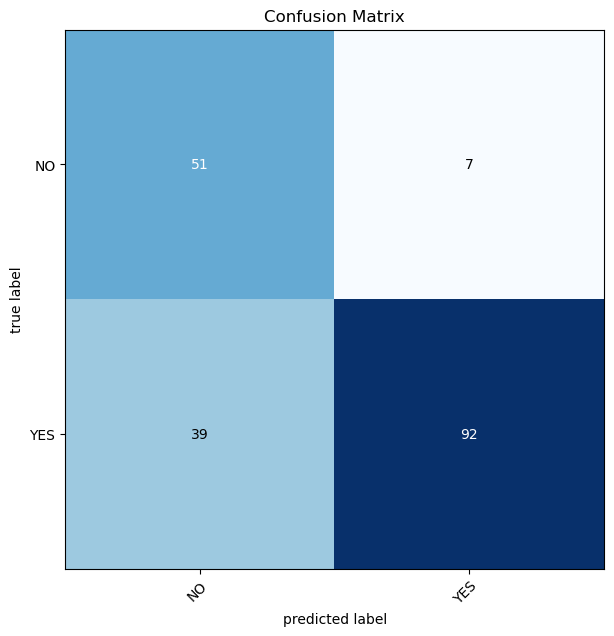

In [285]:
import torch
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# 1. Ensure both y_pred_tensor and test_data.targets are PyTorch tensors
y_pred_tensor = torch.tensor(y_pred_tensor)  # If it's a list, convert to tensor
true_labels_tensor = torch.tensor(test_data.targets)  # Convert test_data.targets (list) to tensor

# 2. Create confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

# 3. Compute the confusion matrix
confmat_tensor = confmat(preds=y_pred_tensor, target=true_labels_tensor)

# 4. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # Convert to NumPy for plotting
    class_names=class_names,          # Replace with your class names
    figsize=(10, 7)                   # Adjust figure size as needed
)

# Display the plot
plt.title("Confusion Matrix")
plt.show()


In [286]:
from sklearn.metrics import classification_report
print(classification_report(true_labels_tensor, y_pred_tensor))


              precision    recall  f1-score   support

           0       0.57      0.88      0.69        58
           1       0.93      0.70      0.80       131

    accuracy                           0.76       189
   macro avg       0.75      0.79      0.74       189
weighted avg       0.82      0.76      0.77       189



In [287]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels_tensor, y_pred_tensor)
true_positives = np.diag(cm)  # Diagonal of confusion matrix
class_totals = cm.sum(axis=1)  # Total samples for each class (row sums)
per_class_accuracy = true_positives / class_totals
#target_labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]
image_label_accuracy=[]
for label, accuracy in zip(class_names, per_class_accuracy):
    print(f"{label} - Accuracy: {accuracy:.4f}")
    image_label_accuracy.append(accuracy)



NO - Accuracy: 0.8793
YES - Accuracy: 0.7023


In [288]:
image_label_accuracy

[0.8793103448275862, 0.7022900763358778]

# SAVING MODEL TRAINING PROCESS FOR LATER RESUMING TRAINING FROM LEFT

In [289]:
# Specify the path where the model will be saved
model_save_path = "CVD_resnet50.pth"

# Save the model's state dictionary and optimizer state
torch.save({
    'model_state_dict': model_resnet50.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch  # Save the current epoch for resuming training later
}, model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to CVD_resnet50.pth


In [305]:
# Load the model and optimizer state from the saved file
checkpoint = torch.load(model_save_path)

# Load the model's state dictionary
model_resnet50.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer's state (optional, only for resuming training)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Resume training from the saved epoch
start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch

print(f"Model loaded from {model_save_path}, resuming from epoch {start_epoch}")


Model loaded from CVD_resnet50.pth, resuming from epoch 17


# SAVING AND LOADING MODEL

In [306]:
from pathlib import Path
#create model directory
Model_Path = Path("resnet50_cvd_model")
Model_Path.mkdir(exist_ok=True,parents=True)
#create model save path
Model_Name = "cvd_image_model_resnet50.pth"
Model_Save_Path = Model_Path / Model_Name
#Save the model State dict
print(f"Model are saving on {Model_Save_Path}")
torch.save(obj=model_resnet50.state_dict(),f=Model_Save_Path)


Model are saving on resnet50_cvd_model/cvd_image_model_resnet50.pth


In [307]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of classes
num_classes = 2  # Adjust this based on your specific task

# Initialize the ResNet-50 model
loaded_model_resnet50 = models.resnet50(pretrained=False)

# Define the original architecture used when the state dictionary was saved
in_features = loaded_model_resnet50.fc.in_features
loaded_model_resnet50.fc = nn.Sequential(
    nn.Linear(in_features, 512),  # Intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),  # Regularization
    nn.Linear(512, 256),  # Intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),  # Regularization
    nn.Linear(256, num_classes)  # Output layer
)

# Load the saved state dictionary
#Model_Save_Path = 'path/to/saved/model.pth'  # Adjust this path
loaded_model_resnet50.load_state_dict(torch.load(Model_Save_Path))

# Move the model to the correct device
loaded_model_resnet50 = loaded_model_resnet50.to(device)

# Set the model to evaluation mode
loaded_model_resnet50.eval()

print("Model loaded and ready for evaluation.")

Model loaded and ready for evaluation.


In [308]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
loaded_model_resnet50.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = loaded_model_resnet50(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor2 = torch.cat(y_preds)

Making predictions: 100%|███████████████████████████| 19/19 [00:10<00:00,  1.77it/s]


In [309]:
y_pred_tensor2
y_pred_tensor==y_pred_tensor2

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [312]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming y_true contains the true labels and y_pred_tensor2 contains the predicted labels
# Convert y_pred_tensor2 to a NumPy array if it is a tensor
y_pred = y_pred_tensor2.numpy() if hasattr(y_pred_tensor2, 'numpy') else y_pred_tensor2
y_true = true_labels_tensor.numpy() if hasattr(true_labels_tensor, 'numpy') else true_labels_tensor
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.7566137566137566
Precision: 0.8180107957885736
Recall: 0.7566137566137566
F1 Score: 0.7659945659945661
Confusion Matrix:
[[51  7]
 [39 92]]
